In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv('AER_credit_card_data.csv', delimiter=',')

In [4]:
df.head(10)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
5,yes,0,23.25000,2.5000,0.044438,91.996670,no,no,0,54,1,1
6,yes,0,27.91667,3.9600,0.012576,40.833330,no,no,2,7,1,5
7,yes,0,29.16667,2.3700,0.076434,150.790000,yes,no,0,77,1,3
8,yes,0,37.00000,3.8000,0.245628,777.821700,yes,no,0,97,1,6
9,yes,0,28.41667,3.2000,0.019780,52.580000,no,no,0,65,1,18


### Preparation

In [9]:
df.card = df.card.map(dict(yes=1, no=0))

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

### Q1 Which numerical variable (among the following 4) has the highest AUC?

In [16]:
numerical = ['reports',
             'age',
             'income',
             'share',
             'expenditure',
             'dependents',
             'months',
             'majorcards',
             'active']

In [25]:
AUC_scores = []
for n in numerical:
    AUC = roc_auc_score(df_train.card, df_train[n])
    if AUC < 0.5:
        AUC = roc_auc_score(df_train.card, -df_train[n])
    else:
        AUC = AUC
    AUC_scores.append((AUC, n))
AUC_scores.sort()
AUC_scores

[(0.5240020979407055, 'age'),
 (0.5294217780967629, 'months'),
 (0.5327757227773791, 'dependents'),
 (0.5343859842838476, 'majorcards'),
 (0.5908049467233478, 'income'),
 (0.6043173411362006, 'active'),
 (0.7166629860689376, 'reports'),
 (0.989183643423692, 'share'),
 (0.991042345276873, 'expenditure')]

### Training the model

In [77]:
y_test = df_test.card
y_train = df_train.card
y_val = df_val.card

AttributeError: 'DataFrame' object has no attribute 'card'

In [28]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [29]:
del df_train['card']
del df_val['card']
del df_test['card']

In [30]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

### Q2 What's the AUC of this model on the validation dataset? (round to 3 digits)

In [31]:
train_val = df_val.to_dict(orient='records')
X_val = dv.transform(train_val)
y_pred = model.predict_proba(X_val)[:, 1]

In [33]:
roc_auc_score(y_val, y_pred).round(3)

0.995

### Q3 At which threshold precision and recall curves intersect?

In [37]:
thresholds = np.linspace(0, 1, 101)

In [39]:
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (actual_positive & predict_positive).sum()   
    fp = (actual_negative & predict_positive).sum() 
    fn = (actual_positive & predict_negative).sum()
    
    P = tp/(tp + fp)
    R = tp/(tp + fn)
    scores.append((t, P, R))


columns = ['thresholds','precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

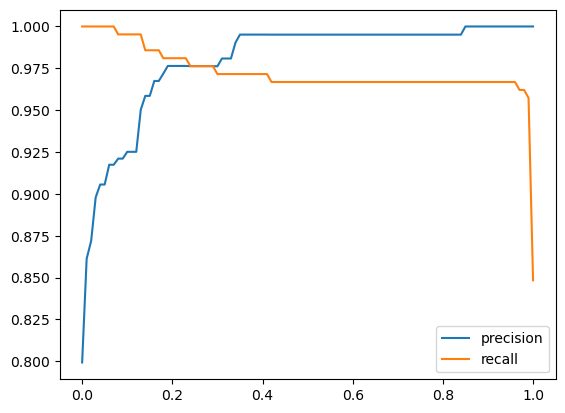

In [41]:
plt.plot(df_scores.thresholds, df_scores['precision'], label='precision')
plt.plot(df_scores.thresholds, df_scores['recall'], label='recall')
plt.legend()

In [44]:
df_scores.iloc[30]

thresholds    0.300000
precision     0.976190
recall        0.971564
Name: 30, dtype: float64

### Q4 At which threshold F1 is maximal?
F1 = 2(P*R)/(P+R)

In [45]:
df_scores['F1'] = 2*(df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

In [57]:
df_scores.sort_values(by=['F1'], ascending=False).head(1)

,thresholds,precision,recall,F1
39,0.39,0.995146,0.971564,0.983213


### Q5 How large is standard devidation of the AUC scores across different folds?

In [60]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [61]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [62]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [94]:
def train(df, y, C):
    dicts = df.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [71]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [87]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    del df_train['card']
    del df_val['card']
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc) 

In [93]:
np.std(scores).round(3)

0.003

### Q6 Which C leads to the best mean score?

In [95]:
Clist = [0.01, 0.1, 1, 10]

In [104]:
columns6 = ['C', 'mean_AUC', 'std_AUC']
df_answer = pd.DataFrame(columns=columns6)
for C in Clist:
    scoresC = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.card.values
        y_val = df_val.card.values
    
        del df_train['card']
        del df_val['card']
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scoresC.append(auc)
    df_answer.loc[len(df_answer.index)] = [C,
                                           np.mean(scoresC).round(3),
                                          np.std(scoresC).round(3)]

In [107]:
df_answer.sort_values(by=['mean_AUC'], ascending=False).head(1)

,C,mean_AUC,std_AUC
2,1.0,0.996,0.003
